<h1 align=center> Predicting bike usage </h1>

## Description
For this activity, we will build a regression model to predict the volume of casual bicycle users on a bike share scheme.  The data we will use is based on the UCI bike sharing data set. The original data can be found [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset), but we will use a slightly modified version.

The data has the following columns. Each row represents one day worth of data.

* **id:** row id
* **season:** spring, summer, autumn, winter 
* **year:** year the data was collected
* **holiday:**  whether the day is considered a holiday (1) or not (0)
* **workingday:** whether the day is a weekend or holiday (1) or not (0)
* **weather:** overall weather conditions on the day
* **temp:** normalized temperature
* **feel_temp:** normalized "feels like" temperature 
* **humidity:** normalized relative humidity
* **windspeed:** normalized wind speed
* **promotion_level:** level of promotion of the bike scheme by the bike company
* **promotion_type:** type of promotion of the bike scheme by the bike company
* **promotion_level_external:** level of promotion of the bike scheme by other organizations
* **promotion_type_external:** type of promotion of the bike scheme by other organizations
* **casual:** number of non-registered user rentals initiated
* **registered:** number of registered user rentals initiated
* **count:** number of total rentals

We will be predicting the number of casual bike users (column name 'casual').

## Import the libraries we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Perform feature selection using a variance threshold
from sklearn.feature_selection import VarianceThreshold

# Feature selection using Recursive Feature Elimimation
from sklearn.feature_selection import RFE

# Sklearn regression algorithms
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV

# Sklearn regression model evaluation functions
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

Define some useful functions 

In [2]:
def linearRegressionSummary(model, column_names):
    '''Show a summary of the trained linear regression model'''

    # Plot the coeffients as bars
    fig = plt.figure(figsize=(8,len(column_names)/3))
    fig.suptitle('Linear Regression Coefficients', fontsize=16)
    rects = plt.barh(column_names, model.coef_,color="lightblue")

    # Annotate the bars with the coefficient values
    for rect in rects:
        width = round(rect.get_width(),4)
        plt.gca().annotate('  {}  '.format(width),
                    xy=(0, rect.get_y()),
                    xytext=(0,2),  
                    textcoords="offset points",  
                    ha='left' if width<0 else 'right', va='bottom')        
    plt.show()
    
def score(model, X, y):
    """Get the model prediction scores using the provided input and target features"""
    
    predictions = model.predict(X)
    print("    R2", r2_score(y, predictions))     
    
def correlatedFeatures(dataset, threshold):
    """Function to list features that are correlated
       Adds the first of the correlated pair only (not both)"""
    
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns    


def kFoldCV(X, y, silent=False):
    """Evaluate linear regression with k-fold cross validation"""
    
    model = LinearRegression()
    
    # Create folds
    seed = 2
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    
    # Perform kfold cross validation
    results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    
    # Show results
    if not silent:
        print(type(model).__name__)
        print("kFoldCV:")
        print("    Fold R2 scores:", results)
        print("    Mean R2 score:", results.mean())
        print("    Std R2 score:", results.std())
    
    # Build a model using all the data and return it
    model.fit(X, y)

    return model



## Load and understand the data


In [3]:
# Load data and inspect the first few rows
dataset = pd.read_csv("./Datasets/bike.csv")
dataset.head()

,id,season,year,holiday,weekday,workingday,weather,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual,registered,cnt
0,12765,winter,2016,0,6,0,cloud,0.344167,0.363625,0.805833,0.160446,7,1,2,2,226,654,880
1,12766,winter,2016,0,0,0,cloud,0.363478,0.353739,0.696087,0.248539,8,1,8,1,125,670,795
2,12767,winter,2016,0,1,1,fair,0.196364,0.189405,0.437273,0.248309,3,1,10,2,75,1229,1304
3,12768,winter,2016,0,2,1,fair,0.200000,0.212122,0.590435,0.160296,0,1,8,3,67,1454,1521
4,12769,winter,2016,0,3,1,fair,0.226957,0.229270,0.436957,0.186900,2,0,5,1,58,1518,1576


In [4]:
# Confirm the data types
dataset.dtypes

id                            int64
season                       object
year                          int64
holiday                       int64
weekday                       int64
workingday                    int64
weather                      object
temp                        float64
feel_temp                   float64
hum                         float64
windspeed                   float64
promotion_level               int64
promotion_type                int64
promotion_level_external      int64
promotion_type_external       int64
casual                        int64
registered                    int64
cnt                           int64
dtype: object

In [5]:
# Check for nulls
dataset.isnull().mean()

id                          0.0
season                      0.0
year                        0.0
holiday                     0.0
weekday                     0.0
workingday                  0.0
weather                     0.0
temp                        0.0
feel_temp                   0.0
hum                         0.0
windspeed                   0.0
promotion_level             0.0
promotion_type              0.0
promotion_level_external    0.0
promotion_type_external     0.0
casual                      0.0
registered                  0.0
cnt                         0.0
dtype: float64

C:\Users\Hichem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 2016.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\Hichem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:81: UserWarning: Attempting to set identical bottom == top == 2016.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\Users\Hichem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:71: UserWarning: Attempting to set identical left == right == 2016.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


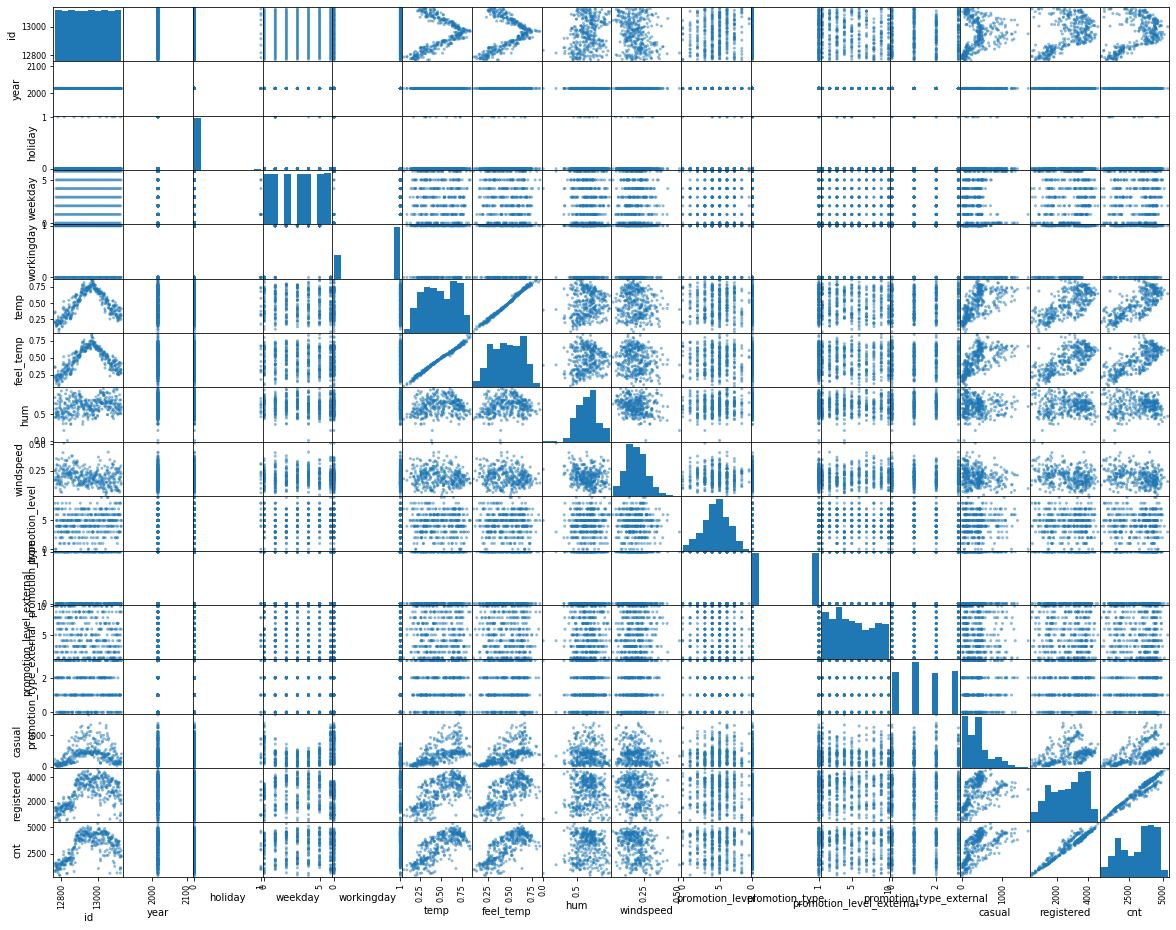

In [6]:
# Plot a scatter matrix
pd.plotting.scatter_matrix(dataset, figsize=(20, 16))
plt.show()

## Thoughts
* The column **id** is useful only for identification and should be removed.
* The column **year** has one unique value and won't be helpful.
* There is some good signs of correlation with the our target variable from **temp**, **feel_temp**, **registered** and **cnt**.
* We spot multicollinearity between the features **temp** and **feel_temp**, and between **registered** and **cnt**.
* **casual**, **registered** and **cnt** are related, in fact **cnt**=**casual**+**registered**. And since we are trying to predict **casual** presenting **registered** and **cnt** with the input variables to a model will cause data leakage.

## Feature engineering

In [7]:
# remove columns
df = dataset.drop(['id', 'registered', 'cnt'], axis=1)

In [8]:
# One-hot-encode the categoricals
categoricals = ['season','weekday','weather']
df = pd.get_dummies(df, columns=categoricals, drop_first=True)
df.head()

,year,holiday,workingday,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,...,season_summer,season_winter,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_fair,weather_rain
0,2016,0,0,0.344167,0.363625,0.805833,0.160446,7,1,2,...,0,1,0,0,0,0,0,1,0,0
1,2016,0,0,0.363478,0.353739,0.696087,0.248539,8,1,8,...,0,1,0,0,0,0,0,0,0,0
2,2016,0,1,0.196364,0.189405,0.437273,0.248309,3,1,10,...,0,1,1,0,0,0,0,0,1,0
3,2016,0,1,0.200000,0.212122,0.590435,0.160296,0,1,8,...,0,1,0,1,0,0,0,0,1,0
4,2016,0,1,0.226957,0.229270,0.436957,0.186900,2,0,5,...,0,1,0,0,1,0,0,0,1,0


## Split into X and y

In [9]:
# Our target feature
y = df.casual

# Our input features
X = df.drop(['casual'], axis=1)

## Rescale

In [10]:
# Rescale the input features
scaler = MinMaxScaler(feature_range=(0,1))
X_ = scaler.fit_transform(X)
X = pd.DataFrame(X_, columns=X.columns)

## Simple linear regression
Build a linear regression model as a baseline, so we can see the effect of any improvements we make later.

In [11]:
# Split into train (2/3) and test (1/3) sets
test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [12]:
# Build and evaluate a linear regression model 
model = LinearRegression()
model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

print('Train set:')
print('\t MAE :', mean_absolute_error(y_train, train_predictions))
print('\t RMSE :', sqrt(mean_squared_error(y_train, train_predictions)))
print('\t R2 :', r2_score(y_train, train_predictions))

print('Test set:')
print('\t MAE :', mean_absolute_error(y_test, test_predictions))
print('\t RMSE :', sqrt(mean_squared_error(y_test, test_predictions)))
print('\t R2 :', r2_score(y_test, test_predictions))

Train set:
	 MAE : 98.91482477754187
	 RMSE : 134.98707102502138
	 R2 : 0.798265855369959
Test set:
	 MAE : 107.20488112565833
	 RMSE : 156.88669278128464
	 R2 : 0.7444590452036942


There's no sign of overfitting, let's examine the model's coefficients :

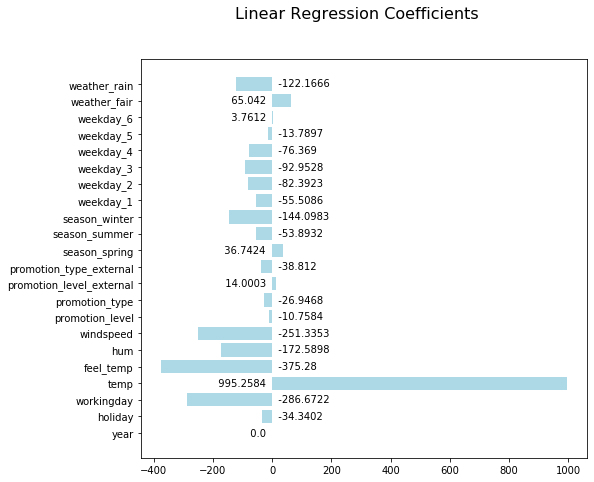

In [13]:
linearRegressionSummary(model, X.columns)

> A simple linear regression model with all the inputs, has a good performance with **R² = 74.45%**. It succeded to eliminate the **year** variable, but failed to spot the multicollinearity between **temp** and **feel_temp**. Also there's a big difference in the magnitude of our inputs. We'll try different techniques to improve the performance of our model.

## Resampling with k-fold cross-validation

Evaluate linear regression with 10-fold cross validation

LinearRegression
kFoldCV:
    Fold R2 scores: [0.77867009 0.7621977  0.80768621 0.66277917 0.75999146 0.60400545
 0.73477313 0.75622157 0.70917569 0.80477441]
    Mean R2 score: 0.7380274883992082
    Std R2 score: 0.06068293222641287


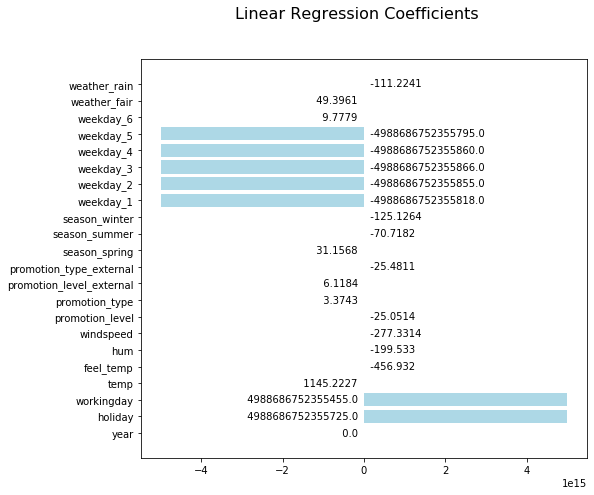

In [14]:
# Evaluate linear regression with k-fold cross validation
model = kFoldCV(X, y)
linearRegressionSummary(model, X.columns)

> * Using 10-fold cross validation, we observe that our linear model has a consistent perofrmance with a **mean R2 score = 0.738** and a **std R2 score = 0.061**.
* It's clear to observe that some features have a huge coefficients values. Looking closely, we see that for each day from Monday to Thursday has a large negative coefficient that will be almostly eliminated by the nature of that day : a working day or a holiday.


## Feature selection

### Remove low variance features
Identify some low variance features, those with variance less than 0.01 and remove them.

In [15]:
X.var()

year                        0.000000
holiday                     0.026720
workingday                  0.216393
temp                        0.057592
feel_temp                   0.049115
hum                         0.023394
windspeed                   0.025126
promotion_level             0.044400
promotion_type              0.250685
promotion_level_external    0.104256
promotion_type_external     0.134599
season_spring               0.189041
season_summer               0.189041
season_winter               0.186286
weekday_1                   0.122505
weekday_2                   0.122505
weekday_3                   0.122505
weekday_4                   0.122505
weekday_5                   0.122505
weekday_6                   0.124462
weather_fair                0.236444
weather_rain                0.039515
dtype: float64

In [16]:
# Identify low variance features
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train)
print('Features with variance value less than 0.01 :', X.columns.values[~selector.get_support()])

Features with variance value less than 0.01 : ['year']


In [17]:
# Remove low variance features
print('Train set old shape :', X_train.shape)

selected_features = X.columns.values[selector.get_support()]

X_train = pd.DataFrame(selector.transform(X_train), columns=selected_features)
X_test = pd.DataFrame(selector.transform(X_test), columns=selected_features)

print('Train set new shape :', X_train.shape)

Train set old shape : (244, 22)
Train set new shape : (244, 21)


### Correlated features
Remove highly correlated features

In [18]:
# Remove highly correlated features
correlated_columns = correlatedFeatures(X_train, 0.8)

print('Highly correlated features to be removed :', correlated_columns)
print('Train set old shape :', X_train.shape)

X_train = X_train.drop(correlated_columns, axis=1)
X_test = X_test.drop(correlated_columns, axis=1)

print('Train set new shape :', X_train.shape)

Highly correlated features to be removed : {'feel_temp'}
Train set old shape : (244, 21)
Train set new shape : (244, 20)


## Apply RFE

Systematically determine number of features to keep

In [19]:
# Build models using from 1 to n-1 features using RFE

for i in range(1,X_train.shape[1]-1):
    print("\nRFE ", i, end="\t")
    
    # Create a model
    model = LinearRegression()

    # Select the best features according to RFE
    selector = RFE(model, n_features_to_select=i)
    selector.fit(X_train, y_train)

    # Transform (remove features not selected)
    X_train_rfe = selector.transform(X_train)
    X_test_rfe = selector.transform(X_test)

    # Evaluate
    model.fit(X_train_rfe, y_train)
    score(model, X_test_rfe, y_test)


RFE  1	    R2 0.3246281329358406

RFE  2	    R2 0.7051208652825429

RFE  3	    R2 0.7044749355460929

RFE  4	    R2 0.7266852555551557

RFE  5	    R2 0.7416662131598455

RFE  6	    R2 0.7411372476279006

RFE  7	    R2 0.7435654092884243

RFE  8	    R2 0.7529284088193229

RFE  9	    R2 0.7500670068841089

RFE  10	    R2 0.7523980442812533

RFE  11	    R2 0.7532168999250441

RFE  12	    R2 0.7579692489593913

RFE  13	    R2 0.7572864333806235

RFE  14	    R2 0.7566481550601374

RFE  15	    R2 0.7552650743183956

RFE  16	    R2 0.7430774998361734

RFE  17	    R2 0.7425498839188188

RFE  18	    R2 0.7425498839188185


From these results, we see that the optimal number of features to retain is 12 because it's associated with the highest value of R2 (0.757969).

In [20]:
# Based on the above, remove the suggested number of features

# Create a model
model = LinearRegression()

# Select the best features according to RFE
selector = RFE(model, n_features_to_select=12)
selector.fit(X_train, y_train)

print('Train set old shape :', X_train.shape)

selected_features = X_train.columns.values[selector.support_]

print('Features to retain :', selected_features)
print('Features to remove :', X_train.columns.values[~selector.support_])

X_train = pd.DataFrame(selector.transform(X_train), columns=selected_features)
X_test = pd.DataFrame(selector.transform(X_test), columns=selected_features)

print('Train set new shape :', X_train.shape)

Train set old shape : (244, 20)
Features to retain : ['holiday' 'workingday' 'temp' 'hum' 'windspeed' 'season_summer'
 'season_winter' 'weekday_2' 'weekday_3' 'weekday_4' 'weather_fair'
 'weather_rain']
Features to remove : ['promotion_level' 'promotion_type' 'promotion_level_external'
 'promotion_type_external' 'season_spring' 'weekday_1' 'weekday_5'
 'weekday_6']
Train set new shape : (244, 12)


## Evaluate a model with the features removed
Now that we have removed a number of features using low-variance removal, highly correlated feature removal and RFE, build and evaluate a linear regression model with this reduced feature set.

Train :
    R2 0.7911155468546125
Test :
    R2 0.7579692489593913


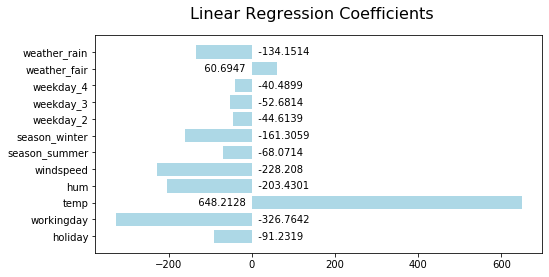

In [21]:
# Build and evaluate a linear regression model with the reduced feature set
model = LinearRegression().fit(X_train, y_train)

print('Train :')
score(model, X_train, y_train)
print('Test :')
score(model, X_test, y_test)

linearRegressionSummary(model, X_train.columns)

> Using different techniques to reduce the number of our input variables helped to improve the peroformance of our linear regression model and make it easier to interpret.

Let's check the model's consistency :

LinearRegression
kFoldCV:
    Fold R2 scores: [0.75871747 0.78251371 0.80979516 0.69481796 0.77363833 0.62289734
 0.76556285 0.7616599  0.73221197 0.82525471]
    Mean R2 score: 0.7527069394764997
    Std R2 score: 0.05545455551109437


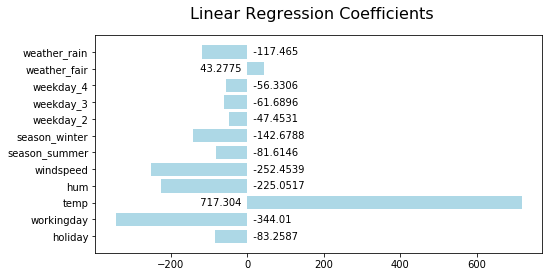

In [22]:
# Evaluate linear regression with k-fold cross validation
X_new = X[X_train.columns.values]
model = kFoldCV(X_new, y)
linearRegressionSummary(model, X_new.columns)

> With k-fold cross validation we can confirm that our model's performance has improved and it's consistent.

## Regularization


Build a model using all the original features.  Let's see if regularisation can do some automatic feature selection!

Train set :
    R2 0.7924264145769783
Test set :
    R2 0.7289091112033701
Alpha : 1.0343958564482105


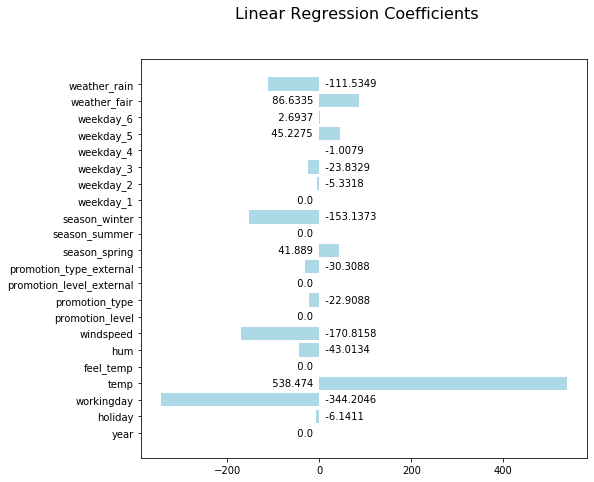

In [23]:
# Split into train (2/3) and test (1/3) sets
test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Create 5 folds
seed = 13
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Create model
model = LassoCV(cv=kfold)

# Fit model
model.fit(X_train, y_train)
print('Train set :')
score(model, X_train, y_train)

# Evaluate
print('Test set :')
score(model, X_test, y_test)

# Print alpha
print('Alpha :', model.alpha_)

# Plot the model's coefficient
linearRegressionSummary(model, X_train.columns)

> **Lasso Regression** has a lower performance than our baseline **Linear Regression** model, but because it has an embedded feature selection method :
* It's more interpretable.
* It has managed to eliminate the collinear feature **feel_temp**.
* It has removed some less important features.